In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/final project')

Mounted at /content/gdrive


In [ ]:
!pip install -q keras

In [ ]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
flickr8k_dir = "FLICKR_8K/Flickr8k_text"

# 1. FLICKR_8K

## 1.1 load Data

In [ ]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]  

In [ ]:
# load train, deve, test list for Flickr_8k data
train_list = load_image_list(os.path.join(flickr8k_dir, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(flickr8k_dir,'Flickr_8k.devImages.txt'))
test_list = load_image_list(os.path.join(flickr8k_dir,'Flickr_8k.testImages.txt'))

let's print a image from the Flickr8K dataset as an example

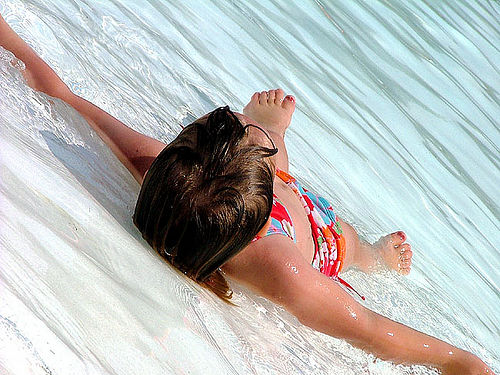

In [ ]:
import PIL
flickr8k_img_dir = "FLICKR_8K/Flicker8k_Dataset"
img_ex = PIL.Image.open(os.path.join(flickr8k_img_dir, '667626_18933d713e.jpg'))
img_ex

## 1.2. Image Encodings

For this part, We will use a pre-trained image encoder: the Inception V3 network. This is a CNN model for object detection.


1. change the size of our input (Flickr_8k image) to a correct size (299x299x3, rgb value from 0 to 1) so it fits the model.


In [ ]:
# let's check the image size and RGB valuefor Flickr_8k
np.asarray(img_ex).shape

(375, 500, 3)

In [ ]:
value = np.asarray(img_ex)
print(np.min(value), np.max(value))

0 255


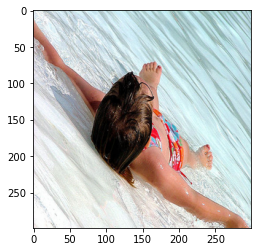

In [ ]:
# get and resize image for the V3 CNN model.
def get_image(image_path, image_name):
    image = PIL.Image.open(os.path.join(image_path, image_name))
    return np.asarray(image.resize((299,299))) / 255.0  

img_ex_resize = get_image(flickr8k_img_dir, '667626_18933d713e.jpg')
plt.imshow(img_ex_resize)                 

In [ ]:
img_ex_resize.shape

(299, 299, 3)

In [ ]:
value = np.asarray(img_ex_resize)
print(np.min(value), np.max(value))

0.0 1.0


2. load the Inception V3 network

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_v3 = InceptionV3(weights='imagenet') 
inception_v3.summary() 

96112376/96112376 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
from tensorflow.keras import Sequential, Model

new_input = inception_v3.input
new_output = inception_v3.layers[-2].output
img_encoder = Model(new_input, new_output) 

In [ ]:
encoded_image = img_encoder.predict(np.array([img_ex_resize]))

1/1 [==============================] - 10s 10s/step


In [ ]:
encoded_image

array([[0.39211532, 0.32112032, 0.57507586, ..., 0.3771243 , 0.30646318,
        0.30139807]], dtype=float32)

3. Use the encoder to encoding the images and store the result in a matrix.

In [ ]:
def img_generator(img_list):
    for img_name in img_list:
        raw_image = get_image(flickr8k_img_dir, img_name)
        new_image =np.reshape(raw_image,(1,299,299,3))
        yield new_image 

In [ ]:
#enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)

In [ ]:
#enc_train[11]

In [ ]:
#enc_dev = img_encoder.predict_generator(img_generator(dev_list), steps=len(dev_list), verbose=1)

In [ ]:
#enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)

In [ ]:
# output_dir = "pt1_encoder_result" 
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)

In [ ]:
#np.save(os.path.join(output_dir,"encoded_images_train.npy"), enc_train)
#np.save(os.path.join(output_dir,"encoded_images_dev.npy"), enc_dev)
#np.save(os.path.join(output_dir,"encoded_images_test.npy"), enc_test)

## 1.3. Text (Caption) Data Preparation 

In [ ]:
from collections import defaultdict

def read_img_captions(filename):
  img_captions = defaultdict(list)
  file = open(filename, 'r')
  for line in file:
    word = line.lower().split()
    img_name = word[0][:-2]
    word = word[1:]
    word = ['<START>'] + word + ['<END>']
    img_captions[img_name].append(word)
  file.close()
  return img_captions

In [ ]:
captions = read_img_captions(os.path.join(flickr8k_dir, "Flickr8k.token.txt"))
print(captions[dev_list[0]])

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


map word to int for later encoding

In [ ]:
int_to_word = defaultdict(int)
tokens = []
for img_name in train_list:
    for caption in captions[img_name]:
        for word in caption:
            if word not in tokens:
                tokens.append(word)
tokens.sort()
for i in range(len(tokens)):
    int_to_word[i+1] = tokens[i]

In [ ]:
word_to_int = {}
for i in range(len(tokens)):
    word_to_int[tokens[i]] = i+1

## 1.4. LSTM Caption Generator

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate

from google.colab import drive

import random

In [ ]:
max_len = max(len(caption) for imgId in train_list for caption in captions[imgId])
max_len

40

In [ ]:
embedding_size=300
word_size = len(word_to_int)+1

img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(max_len)(img_enc)

text_input = Input(shape=(max_len,))
text_emb = Embedding(word_size, embedding_size, input_length=max_len)(text_input)
concat = Concatenate()([images,text_emb])
x = Bidirectional(LSTM(256, return_sequences=False))(concat)
out = Dense(word_size, activation='softmax')(x)
model = Model(inputs=[img_input,text_input],outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 300)          614700      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 40, 300)      0           ['dense[0][0]']                  
                                                                                            

In [ ]:
enc_train = np.load("/content/gdrive/My Drive/final project/pt1_encoder_result/encoded_images_train.npy")

In [ ]:
def training_batch(batch_size=128):
    in1 = np.zeros((batch_size, 2048))
    in2 = np.zeros((batch_size, max_len))
    out = np.zeros((batch_size, word_size))
    batch = 0
    while True:
        for j in range(len(train_list)):
            for caption in captions[train_list[j]]:
                wid = np.zeros(max_len)
                for i in range(len(caption)-1): # for each word
                    if batch < batch_size:
                        pw = np.zeros(word_size)
                        wid[i] = word_to_int[caption[i]]
                        pid = word_to_int[caption[i+1]]
                        pw[pid] = 1
                        in2[batch] = wid
                        in1[batch] = enc_train[j].reshape(1,2048)
                        out[batch] = pw
                        batch = batch+1
                    else:
                        batch = 0
                        yield ([in1,in2], out)


In [ ]:
batch_size = 128
batch = training_batch(batch_size)
steps = len(train_list) * max_len // batch_size 

# model.fit_generator(batch, steps_per_epoch=steps, verbose=True, epochs=10)

In [ ]:
output_dir = "pt3_result" 
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [ ]:
# model.save(os.path.join(output_dir,"model.h5"))
model.load_weights("/content/gdrive/My Drive/final project/pt3_result/model.h5")

In [ ]:
def img_decoder(enc_image,model): 

    pred = ['<START>']
    input = np.zeros((1,max_len))
    input[0][0] = word_to_int['<START>']
    while (pred[-1] != '<END>') and len(pred) < max_len:
        img = enc_image.reshape(1,2048)
        result = model.predict((img, input),verbose=False)
        indice = np.argmax(result)
        pred.append(int_to_word[indice])
        input[0][len(pred)-1] = indice
    return pred

In [ ]:
enc_test = np.load("/content/gdrive/My Drive/final project/pt1_encoder_result/encoded_images_test.npy")
enc_dev = np.load("/content/gdrive/My Drive/final project/pt1_encoder_result/encoded_images_dev.npy")

['<START>', 'a', 'boy', 'does', 'a', 'trick', 'on', 'a', 'skateboard', '.', '<END>']


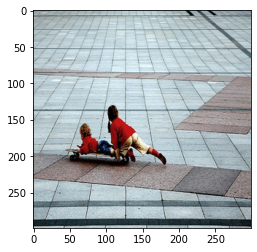

In [ ]:
plt.imshow(get_image(flickr8k_img_dir,dev_list[0]))
print(img_decoder(enc_dev[0],model))

['<START>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'playing', 'with', 'a', 'man', 'in', 'a', 'red', 'uniform', '.', '<END>']


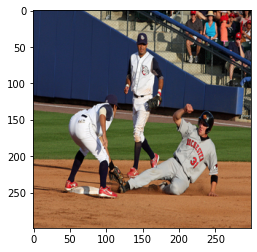

In [ ]:
plt.imshow(get_image(flickr8k_img_dir,dev_list[100]))
print(img_decoder(enc_dev[100],model))

['<START>', 'a', 'basketball', 'player', 'in', 'a', 'red', 'uniform', 'is', 'running', 'on', 'the', 'field', '.', '<END>']


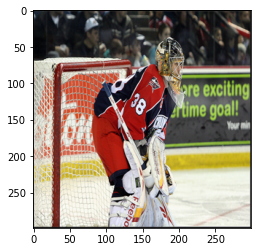

In [ ]:
plt.imshow(get_image(flickr8k_img_dir,dev_list[200]))
print(img_decoder(enc_dev[200],model))

# 2. Hateful Memes

## 2.1. Data preprocessing



In [ ]:
import os
import h5py
import matplotlib.pyplot as plt
import pandas as pd 
import time, pickle, pandas
import numpy as np
import random
import copy
import tensorflow 
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
data_dir = 'hateful_meme/data/'
img_dir = data_dir + '/img/'
train_path = data_dir + "train.jsonl"
test_path = data_dir + "test.jsonl"
dev_path = data_dir + "dev.jsonl"

In [ ]:
train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(test_path, lines=True)
dev_data = pd.read_json(dev_path, lines=True)
train_data_0 = train_data.loc[train_data['label'] == 0]


In [ ]:
train_data.head(10)

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
5,16952,img/16952.png,0,go sports! do the thing! win the points!
6,76932,img/76932.png,0,fine you're right. now can we fucking drop it?
7,70914,img/70914.png,0,tattoos are bad for your health i know 5 milli...
8,2973,img/02973.png,0,how long can i run? till the chain tightens
9,58306,img/58306.png,0,what is he hiding? we need to see his tax retu...


In [ ]:
dev_data.head(10)

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime
5,5279,img/05279.png,1,"knowing white people , that's probably the bab..."
6,1796,img/01796.png,1,life hack #23 how to get stoned with no weed
7,53046,img/53046.png,1,"you've heard of elf on a shelf, now get ready for"
8,82301,img/82301.png,1,cooooooooooooon!!!!
9,31752,img/31752.png,1,when you get to choose your own mental illness


### a. Data class

In [ ]:
import json
class HatefulMemes(keras.utils.Sequence):
    
    def __init__(self, data_dir):
        super().__init__()
        self.data = [json.loads(l) for l in open(data_dir)]
        self.data_path = os.path.dirname(data_dir)
        
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.data_path, self.data[idx]["img"])).convert("RGB")
        text = self.data[idx]["text"]
        label = self.data[idx]["label"]
        image = np.asarray(image.resize((299,299)))
        return image, text, label
            
    def load_img(self, idx):
        image = Image.open(os.path.join(self.data_path, self.data[idx]["img"])).convert("RGB")
        image = np.asarray(image.resize((299,299)))
        return image
    
    def get_label(self, index: int):
        label = self.data[index]["label"]
        return label
    
    def get_text(self, index: int):
        text = self.data[index]["text"]
        return text
    
    def __len__(self):
        return len(self.data)
    
    #add
    def get_imgname(self, index: int):
        imgname = self.data[index]["img"]
        return imgname[4:]

In [ ]:
train_dataset = HatefulMemes(train_path)
val_dataset = HatefulMemes(dev_path)
test_dataset = HatefulMemes(test_path)


In [ ]:
train_dataset.get_imgname(0)

'42953.png'

In [ ]:
text = train_dataset.get_text(1)
print(text)

don't be afraid to love again everyone is not like your ex


In [ ]:
from random import sample

In [ ]:
train_ids = [id for id in range(0, len(train_dataset))]
# train_sample = sample(train_ids, 1000)
# imgs = [train_dataset.load_img(id) for id in train_ids]

## UNCOMMENT IF NEED TO RELOAD
# train_img_list = []
# for id in train_ids:
#   # print(id)
#   img = train_dataset.load_img(id)
#   train_img_list.append(img)
# print(train_img_list[:5])

# train_ids = train_data["id"].tolist()
# imgs = []
# train_names = train_data["img"].tolist()
# for name in train_names:
#   img = get_image(data_dir, name)
# print(train_ids)

### b. save training imgs 

In [ ]:
#output_path = "/content/drive/MyDrive/hateful_meme/data/train_img_sample/"
#if not os.path.exists(output_path):
  #os.mkdir(output_path) 
#np.save(os.path.join(output_path,"train_images_sample.npy"), train_img_list)

In [ ]:
train_sample = np.load("hateful_meme/data/train_img_sample/train_images_sample.npy", allow_pickle=True)
# print(enc_train)

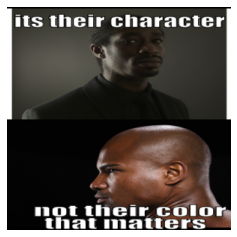

In [ ]:
plt.figure(figsize=(4,5));plt.imshow(train_sample[0]); plt.axis(False);plt.show()

In [ ]:
print(len(train_sample))

8500


In [ ]:
print('Data size of training data: %d samples' % len(train_dataset))
print('Data size of validation data: %d samples' % len(val_dataset))
print('Data size of test data: %d samples' % len(test_dataset))

print('Data size of training data 0: %d samples' % len(train_data_0))


Data size of training data: 8500 samples
Data size of validation data: 500 samples
Data size of test data: 1000 samples
Data size of training data 0: 5450 samples


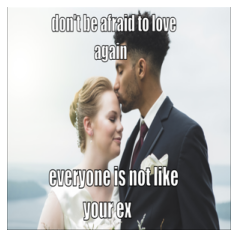

don't be afraid to love again everyone is not like your ex
0
(299, 299, 3)


In [ ]:
sample_memeID = 1
img, text, label = train_dataset[sample_memeID]

# Show input image.
plt.figure(figsize=(4,5));plt.imshow(img); plt.axis(False);plt.show()

# Show input plot (untokenized).
print(text)
print(label)
print(img.shape)

##2.2: Image captions generating using LSTM trained with Flickr_8k dataset.

To generate the caption for the images on hateful memes dataset, we first attempted use the bidirectional LSTM trained above on Flickr_8k. 

Since the model was trained on an entirely different dataset and the images and captions in Flickr_8k are quite limited on varieties and types, the predicted captions might be limited on vocablary and the performance might not be optimal. We might also try to use Bert to generate the captions on latter attempt. 

In [ ]:
model.load_weights("/content/gdrive/My Drive/final project/pt3_result/model.h5")

In [ ]:
meme_img_dir = "hateful_meme/data/img"

In [ ]:
def meme_img_generator(img_dataset):
    #for img_name in img_list:
    for i in range(len(img_dataset)):
        img_name = img_dataset.get_imgname(i)
        raw_image = get_image(meme_img_dir, img_name)
        raw_image = raw_image[:, :, :3]
        new_image =np.reshape(raw_image,(1,299,299,3))
        yield new_image 

In [ ]:
#meme_enc_test = img_encoder.predict_generator(meme_img_generator(test_dataset), steps=len(test_dataset), verbose=1)
#meme_enc_val = img_encoder.predict_generator(meme_img_generator(val_dataset), steps=len(val_dataset), verbose=1)
#meme_enc_train = img_encoder.predict_generator(meme_img_generator(train_dataset), steps=len(train_dataset), verbose=1)

In [ ]:
output_dir = "hateful_meme/pt1_enc_results" 
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [ ]:
#np.save(os.path.join(output_dir,"encoded_images_test.npy"), meme_enc_test)
#np.save(os.path.join(output_dir,"encoded_images_val.npy"), meme_enc_val)
#np.save(os.path.join(output_dir,"encoded_images_train.npy"), meme_enc_train)

In [ ]:
meme_enc_test = np.load("/content/gdrive/My Drive/final project/hateful_meme/pt1_enc_results/encoded_images_test.npy")
meme_enc_val = np.load("/content/gdrive/My Drive/final project/hateful_meme/pt1_enc_results/encoded_images_val.npy")
meme_enc_train = np.load("/content/gdrive/My Drive/final project/hateful_meme/pt1_enc_results/encoded_images_train.npy")

['<START>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'running', 'down', 'a', 'street', '.', '<END>']


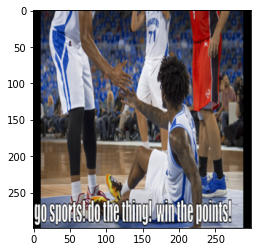

In [ ]:
plt.imshow(get_image(meme_img_dir,train_dataset.get_imgname(5)))
print(img_decoder(meme_enc_train[5],model))

### Save generated result in the original dataframes

In [ ]:
output_dir = "hateful_meme/caption_results" 
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [ ]:
#test_data['caption'] = test_data.apply(lambda row : ' '.join(img_decoder(meme_enc_test[row.name],model)[1:-2]), axis = 1)
#test_caption = test_data.to_json()

In [ ]:
#dev_data['caption'] = dev_data.apply(lambda row : ' '.join(img_decoder(meme_enc_val[row.name],model)[1:-2]), axis = 1)
#dev_caption = dev_data.to_json()

In [ ]:
#with open('hateful_meme/caption_results/dev_caption.json', 'w') as f:
  #f.write(dev_caption)

In [ ]:
#train_data['caption'] = train_data.apply(lambda row : ' '.join(img_decoder(meme_enc_train[row.name],model)[1:-2]), axis = 1)
#train_caption = train_data.to_json()

In [ ]:
#with open('hateful_meme/caption_results/test_caption.json', 'w') as f:
  #f.write(test_caption)

In [ ]:
#with open('hateful_meme/caption_results/train_caption.json', 'w') as f:
  #f.write(train_caption)

## 2.3 Approach 1: Hateful Memes Classification using captions and texts

We will concatenate the image captions generated above and the "text" column of the meme together to a new "information" column. We will use a pretrained BERT model (Bidirectional Encoder Representations from Transformers https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4) to do the classification task with the "information".

In [ ]:
!pip install bert-tensorflow==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 4.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split

from bert import tokenization

In [ ]:
tf.gfile = tf.io.gfile

In [ ]:
train_path = "hateful_meme/caption_results/train_caption.json"
#dev_path = "hateful_meme/caption_results/dev_caption.json"
#test_path = "hateful_meme/caption_results/test_caption.json"
train_caption = pd.read_json(train_path)
#dev_caption = pd.read_json(dev_path)
#test_caption = pd.read_json(test_path)

In [ ]:
train_caption["information"] = "Image: " + train_caption.caption + " with meme: " + train_caption.text
#dev_caption["information"] = "Image: " + dev_caption.caption + " with meme" + dev_caption.text
#test_caption["information"] = "Image: " + test_caption.caption + " with meme" + test_caption.text

In [ ]:
#train_caption["information"][0]

In [ ]:
train_caption.head()

,id,img,label,text,caption,information
0,42953,img/42953.png,0,its their character not their color that matters,a man with a sunglasses and a woman in a sungl...,Image: a man with a sunglasses and a woman in ...
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,a man in a red shirt is smiling and sits on a ...,Image: a man in a red shirt is smiling and sit...
2,13894,img/13894.png,0,putting bows on your pet,a man is sitting on a bench,Image: a man is sitting on a bench with meme: ...
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,a man in a red shirt is running down a street,Image: a man in a red shirt is running down a ...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",a man and woman pose for a picture,Image: a man and woman pose for a picture with...


In [ ]:
#dev_caption.head()

In [ ]:
#test_caption.head()

In [ ]:
#X_train, y_train = train_caption.information.values, train_caption.label.values
#X_dev, y_dev = dev_caption.information.values, dev_caption.label.values
#X_test = test_caption.information.values
X_train, X_test, y_train, y_test = train_test_split(train_caption.information, train_caption.label, test_size=0.2, random_state=42)

In [ ]:
#!pip install bert-tensorflow

In [ ]:
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_lm = hub.KerasLayer(encoder_url, trainable=True)

In [ ]:
def bert_model(bert_layer, seq_length):
    input_word_ids = Input(shape=(seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(seq_length,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(seq_length,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    #clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(sequence_output[:, 0, :])
    
    return Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    #model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    
    #return model

In [ ]:
bert = bert_model(bert_lm, 160)
bert.summary()
bert.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 160)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 160)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 160, 1024)]               'input_mask[0][0]',       

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# if re-train, uncomment this to resets all state generated by Keras.
#from keras import backend as K
#K.clear_session()

In [ ]:
tokenizer = tokenization.FullTokenizer(bert_lm.resolved_object.vocab_file.asset_path.numpy(), bert_lm.resolved_object.do_lower_case.numpy())

In [ ]:
def bert_encode(text, seq_length):
    tokenlist = []
    masklist = []
    segmentlist = []
    for words in text:
        #print(words)
        wordlist = tokenizer.tokenize(words)
        wordlist = wordlist[:seq_length-2]
        input_sequence = ["[CLS]"] + wordlist + ["[SEP]"]
        pad_len = seq_length - len(input_sequence)
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * seq_length
        tokenlist.append(tokens)
        masklist.append(pad_masks)
        segmentlist.append(segment_ids)
    
    return np.array(tokenlist), np.array(masklist), np.array(segmentlist)

In [ ]:
#train_input = bert_encode(X_train, 160)
#dev_input = bert_encode(X_dev, 160)
#test_input = bert_encode(X_test, 160)

train_input = bert_encode(X_train.values,  160)
test_input = bert_encode(X_test.values,  160)
train_labels = y_train.values
test_labels = y_test.values

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
train_his = bert.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=20,
    callbacks=[checkpoint],
    batch_size=10,
    steps_per_epoch=15
)

Epoch 1/20
15/15 [==============================] - 184s 11s/step - loss: 0.7037 - accuracy: 0.4933 - auc: 0.5168 - val_loss: 0.6520 - val_accuracy: 0.6301 - val_auc: 0.6160
Epoch 2/20
15/15 [==============================] - 82s 6s/step - loss: 0.6450 - accuracy: 0.6333 - auc: 0.6455 - val_loss: 0.6451 - val_accuracy: 0.6346 - val_auc: 0.6276
Epoch 3/20
15/15 [==============================] - 83s 6s/step - loss: 0.6308 - accuracy: 0.6933 - auc: 0.6392 - val_loss: 0.6375 - val_accuracy: 0.6640 - val_auc: 0.6547
Epoch 4/20
15/15 [==============================] - 63s 4s/step - loss: 0.6707 - accuracy: 0.6867 - auc: 0.6345 - val_loss: 0.6849 - val_accuracy: 0.5654 - val_auc: 0.5795
Epoch 5/20
15/15 [==============================] - 64s 5s/step - loss: 0.6501 - accuracy: 0.6200 - auc: 0.6462 - val_loss: 0.6486 - val_accuracy: 0.6419 - val_auc: 0.6165
Epoch 6/20
15/15 [==============================] - 85s 6s/step - loss: 0.7087 - accuracy: 0.5867 - auc: 0.5522 - val_loss: 0.6346 - val_a

Performance of the classifier on train and val sets:

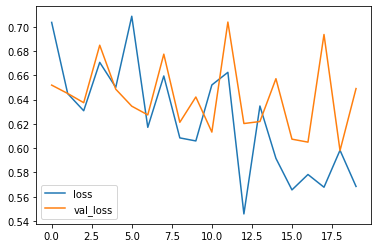

In [ ]:
plt.plot(train_his.history["loss"], label="loss")
plt.plot( train_his.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

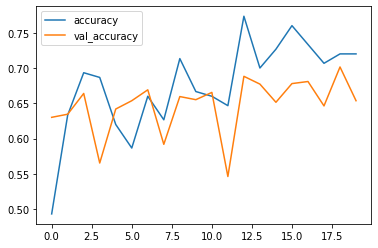

In [ ]:
plt.plot(train_his.history["accuracy"], label="accuracy")
plt.plot( train_his.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

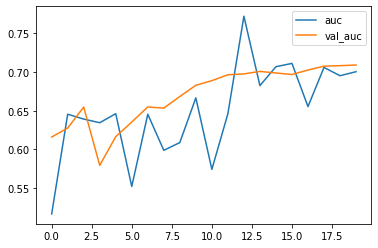

In [ ]:
plt.plot(train_his.history["auc"], label="auc")
plt.plot( train_his.history["val_auc"], label="val_auc")
plt.legend()
plt.show()

Performance of the classifier on test set:

In [ ]:
bert.load_weights('model.h5')
test_pred = bert.predict(test_input)
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
y_actual = list(y_test)
y_prob = list(test_pred.reshape(len(test_pred), ))
print("AUC: ", roc_auc_score(y_actual, y_prob))

54/54 [==============================] - 60s 1s/step
AUC:  0.7518452093023257


In [ ]:
def predict_label(y_actual, y_prob):
    #find best threshold
    acc = 0.5
    best_th = 0
    best_y_pred = []
    for threshold in np.arange(0,1,0.01):
        y_pred = []
        for y in y_prob:
            if y > threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
        if balanced_accuracy_score(y_actual, y_pred) > acc:
            acc = balanced_accuracy_score(y_actual, y_pred)
            best_th = threshold
            best_y_pred = y_pred
    return best_th, best_y_pred

In [ ]:
th, y_pred = predict_label(y_actual, y_prob)

In [ ]:
print("Accuracy: ", balanced_accuracy_score(y_actual, y_pred))

Accuracy:  0.6989209302325581


Let's see some example of the prediction:

In [ ]:
train_caption["img"] = train_caption["img"].apply(lambda x:x[4:])
train_caption.head()

,id,img,label,text,caption,information
0,42953,42953.png,0,its their character not their color that matters,a man with a sunglasses and a woman in a sungl...,Image: a man with a sunglasses and a woman in ...
1,23058,23058.png,0,don't be afraid to love again everyone is not ...,a man in a red shirt is smiling and sits on a ...,Image: a man in a red shirt is smiling and sit...
2,13894,13894.png,0,putting bows on your pet,a man is sitting on a bench,Image: a man is sitting on a bench with meme: ...
3,37408,37408.png,0,i love everything and everybody! except for sq...,a man in a red shirt is running down a street,Image: a man in a red shirt is running down a ...
4,82403,82403.png,0,"everybody loves chocolate chip cookies, even h...",a man and woman pose for a picture,Image: a man and woman pose for a picture with...


In [ ]:
from PIL import Image
def predict_result(img_name):
    img = Image.open("hateful_meme/data/img/"+img_name)
    display(img)
    information = train_caption[train_caption.img==img_name].information.item()
    print(information)
    information = np.array(information).reshape(1,)
    imgEncoded = bert_encode(information, 160)
    print(f'Label: {"Hateful" if (train_caption[train_caption.img==img_name].label.item() == 1) else "Not Hateful"}')
    print(f'Prediction: {"Hateful" if (bert.predict(imgEncoded).item() >= th) else "Not Hateful"}')
    print(f'Predicted prob: {bert.predict(imgEncoded).item():.4f}')

15872.png


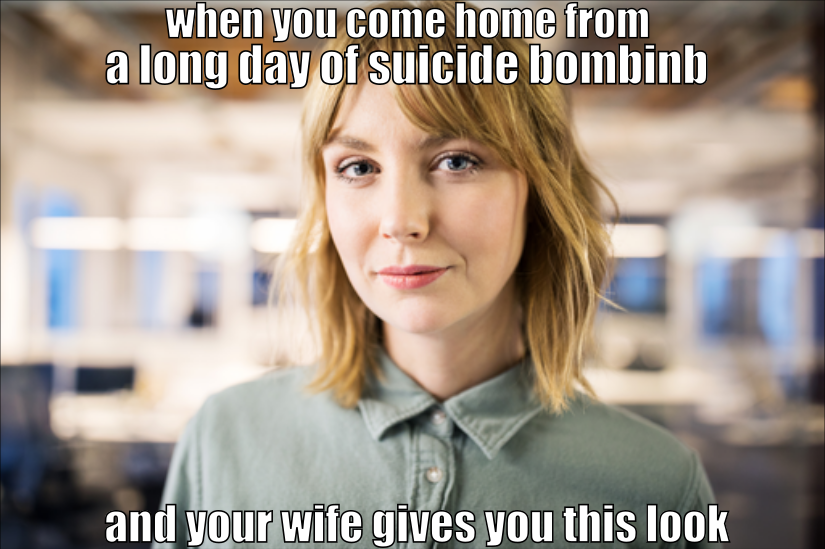

Image: a man wearing a tank top is smiling with meme: when you come home from a long day of suicide bombinb and your wife gives you this look
Label: Not Hateful
1/1 [==============================] - 0s 62ms/step
Prediction: Hateful
1/1 [==============================] - 0s 34ms/step
Predicted prob: 0.4762



10743.png


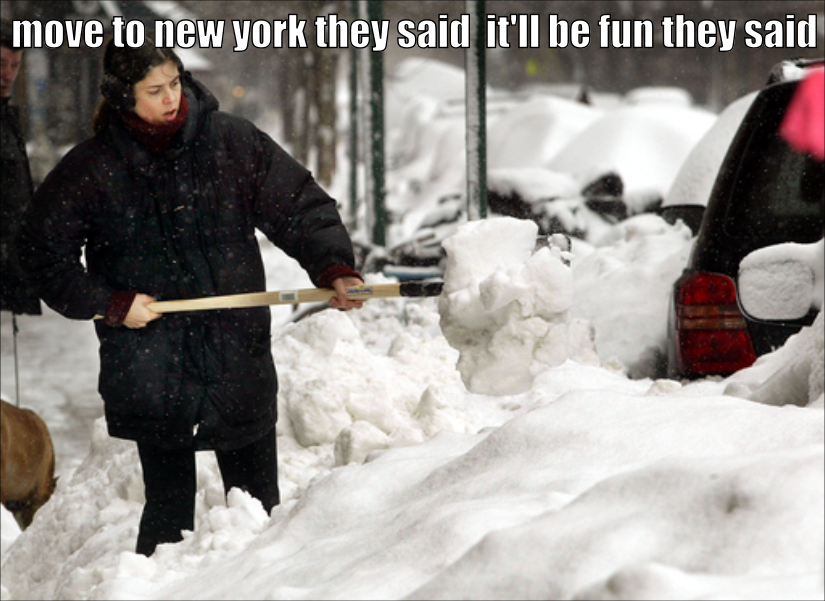

Image: a man is riding a red and white dog with meme: move to new york they said it'll be fun they said
Label: Not Hateful
1/1 [==============================] - 0s 49ms/step
Prediction: Not Hateful
1/1 [==============================] - 0s 35ms/step
Predicted prob: 0.2161



25719.png


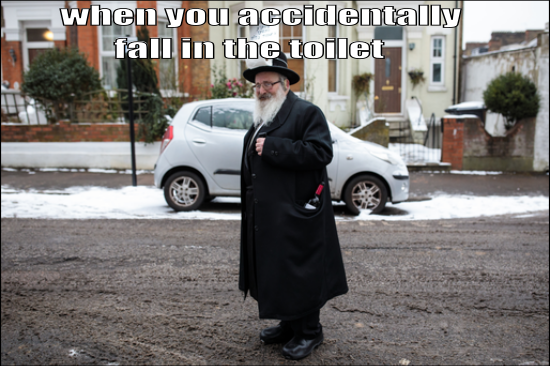

Image: a man in a red shirt is walking down a street with meme: when you accidentally fall in the toilet
Label: Not Hateful
1/1 [==============================] - 0s 51ms/step
Prediction: Not Hateful
1/1 [==============================] - 0s 33ms/step
Predicted prob: 0.2461





In [ ]:
test_img_set = train_caption[train_caption.index.isin(X_test.index)]
test_samples = list(test_img_set["img"][4:7])
for img in test_samples:
    print(img)
    predict_result(img)
    print("\n\n")